In [4]:
# --- Import des bibliothèques ---
import pandas as pd
import os
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# --- Parcourir les fichiers du dossier ---
root_dataset = '/content/drive/MyDrive/defi-ia-2025-cnes'
for dirname, _, filenames in os.walk(root_dataset):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import des fichiers
spectra_train = np.load(f'{root_dataset}/spectra.npy')
auxiliary_train = pd.read_csv(f'{root_dataset}/auxiliary.csv')
targets_train = pd.read_csv(f'{root_dataset}/targets.csv')

print("spectra_train shape:", spectra_train.shape)
print("auxiliary_train shape:", auxiliary_train.shape)
print("targets_train shape:", targets_train.shape)

Mounted at /content/drive
/content/drive/MyDrive/defi-ia-2025-cnes/spectra.npy
/content/drive/MyDrive/defi-ia-2025-cnes/spectra_test.npy
/content/drive/MyDrive/defi-ia-2025-cnes/auxiliary_test.csv
/content/drive/MyDrive/defi-ia-2025-cnes/auxiliary.csv
/content/drive/MyDrive/defi-ia-2025-cnes/targets.csv
/content/drive/MyDrive/defi-ia-2025-cnes/pred_h2o_xg.npy
/content/drive/MyDrive/defi-ia-2025-cnes/pred_clouds_xg.npy
/content/drive/MyDrive/defi-ia-2025-cnes/oof_h2o_deep.npy
/content/drive/MyDrive/defi-ia-2025-cnes/oof_clouds_deep.npy
/content/drive/MyDrive/defi-ia-2025-cnes/pred_h2o_deep.npy
/content/drive/MyDrive/defi-ia-2025-cnes/pred_clouds_deep.npy
/content/drive/MyDrive/defi-ia-2025-cnes/oof_h2o_xg.npy
/content/drive/MyDrive/defi-ia-2025-cnes/oof_clouds_xg.npy
spectra_train shape: (3000, 52, 3)
auxiliary_train shape: (3000, 5)
targets_train shape: (3000, 3)


**Threshold**

In [8]:
from sklearn.metrics import accuracy_score
def get_best_threshold(y_true, y_pred_oof):
    best_acc = 0
    best_thresh = 0.5

    # On teste tous les seuils de 0.20 à 0.80
    for thresh in np.arange(0.2, 0.8, 0.005):
        acc = accuracy_score(y_true, (y_pred_oof >= thresh).astype(int))
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh

    return best_thresh, best_acc

**Import Predictions des deux modèles**

In [13]:
#Xgboost

try:
    oof_h2o = np.load(f'{root_dataset}/oof_h2o_xg.npy')
    oof_clouds = np.load(f'{root_dataset}/oof_clouds_xg.npy')

    pred_h2o_xg = np.load(f'{root_dataset}/pred_h2o_xg.npy')
    pred_clouds_xg = np.load(f'{root_dataset}/pred_clouds_xg.npy')

    print("✅ Tous les fichiers sont chargés avec succès !")

except FileNotFoundError as e:
    print(f"Erreur : Fichier introuvable. {e}")

📂 Chargement des prédictions sauvegardées...
✅ Tous les fichiers sont chargés avec succès !


In [14]:
#DeepResnet
print("📂 Chargement des prédictions sauvegardées...")

try:
    # Chargez vos prédictions XGBoost (si vous les aviez sauvegardées)
    # Sinon, remplacez par vos variables si elles sont encore en mémoire
    oof_cnn_h2o = np.load(f'{root_dataset}/oof_h2o_deep.npy')
    oof_cnn_clouds = np.load(f'{root_dataset}/oof_clouds_deep.npy')

    # Chargez vos prédictions Deep ResNet (celles du 96.5%)
    pred_deep_h2o = np.load(f'{root_dataset}/pred_h2o_deep.npy')
    pred_deep_clouds = np.load(f'{root_dataset}/pred_clouds_deep.npy')

    print("✅ Tous les fichiers sont chargés avec succès !")

except FileNotFoundError as e:
    print(f"Erreur : Fichier introuvable. {e}")

📂 Chargement des prédictions sauvegardées...
✅ Tous les fichiers sont chargés avec succès !


In [62]:
#Poids
w_xgb = 0.5
w_deep = 0.5

oof_blend_h2o = (w_xgb * oof_h2o) + (w_deep * oof_cnn_h2o)

#On calcule le seuil optimal pource ce mélange
th_blend_h2o = get_best_threshold(targets_train['eau'], oof_blend_h2o)
oof_blend_clouds  = (w_xgb * oof_clouds ) + (w_deep * oof_cnn_clouds)
th_blend_clouds = get_best_threshold(targets_train['nuage'], oof_blend_clouds)
print(f" Seuil h20  : {th_blend_h2o}")
print(f" Seuil nuage  : {th_blend_clouds}")

 Seuil h20  : 0.5350000000000004
 Seuil nuage  : 0.47000000000000025


In [57]:
import pandas as pd
import numpy as np

# --- 1. DÉFINITION DES POIDS ---
# On donne la majorité à XGBoost (votre meilleur modèle)
# On laisse le Deep ResNet corriger les hésitations


# --- 2. CALCUL DU MÉLANGE (BLENDING) ---

# H2O
# final_proba_h2o = XGBoost
# pred_ml_h2o     = Deep ResNet
blend_proba_h2o = (w_xgb * pred_h2o_xg) + (w_deep * pred_deep_h2o)

# CLOUDS
# On suppose la même logique pour les nuages
blend_proba_clouds = (w_xgb * pred_clouds_xg) + (w_deep * pred_deep_clouds)

# --- 3. APPLICATION DES SEUILS OPTIMISÉS ---
# Utilisez les valeurs 'th_h' et 'th_c' calculées juste avant avec les OOF
# Si vous ne les avez plus, remettez 0.5 par défaut, mais les seuils optimisés sont mieux.
seuil_h2o = th_blend_h2o if 'th_h' in locals() else 0.5
seuil_clouds = th_blend_clouds if 'th_c' in locals() else 0.5

final_decision_h2o = (blend_proba_h2o >= seuil_h2o).astype(int)
final_decision_clouds = (blend_proba_clouds >= seuil_clouds).astype(int)

# --- 4. GÉNÉRATION DU CSV ---
submission_df = pd.DataFrame({
    'id': range(len(final_decision_h2o)),
    'eau': final_decision_h2o,
    'nuage': final_decision_clouds
})

submission_df.set_index('id', inplace=True)
submission_df.to_csv("submission_XGB_RESNET_blend.csv")

**Corrélation des résultats du Blending**

In [63]:
import numpy as np

# --- Calcul des corrélations ---
# On compare les vecteurs de probabilités (pas les 0/1, mais les scores bruts)

corr_h2o = np.corrcoef(pred_h2o_xg, pred_deep_h2o)[0, 1]
corr_clouds = np.corrcoef(pred_clouds_xg, pred_deep_clouds)[0, 1]

print(f"📊 Corrélation XGBoost vs ResNet (EAU)    : {corr_h2o:.4f}")
print(f"📊 Corrélation XGBoost vs ResNet (NUAGES) : {corr_clouds:.4f}")

📊 Corrélation XGBoost vs ResNet (EAU)    : 0.9817
📊 Corrélation XGBoost vs ResNet (NUAGES) : 0.9604


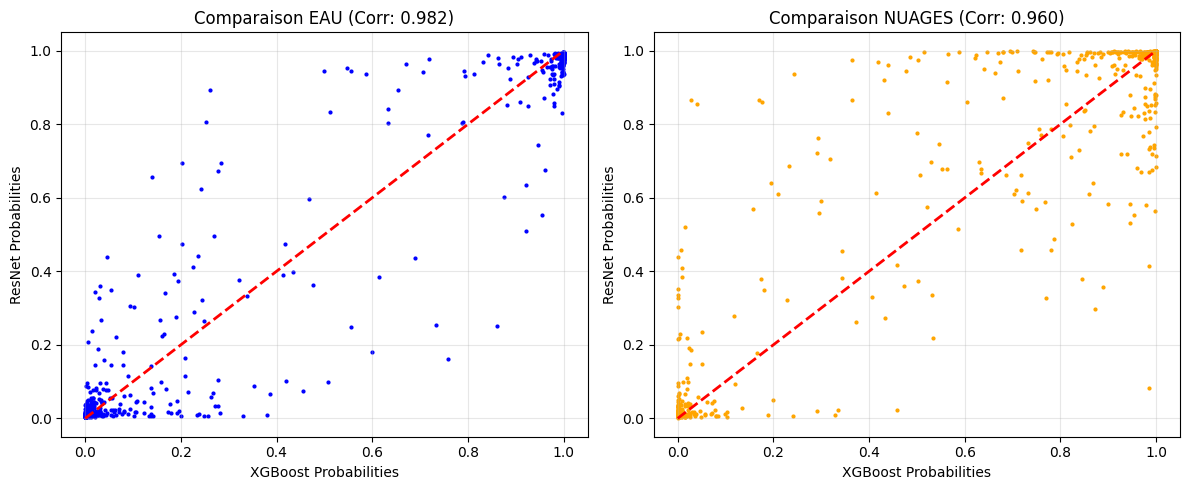

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# --- Graphique EAU ---
plt.subplot(1, 2, 1)
plt.scatter(pred_h2o_xg, pred_deep_h2o, alpha=1, s=4, c='blue')
plt.plot([0, 1], [0, 1], 'r--', lw=2) # Diagonale parfaite
plt.xlabel('XGBoost Probabilities')
plt.ylabel('ResNet Probabilities')
plt.title(f'Comparaison EAU (Corr: {corr_h2o:.3f})')
plt.grid(True, alpha=0.3)

# --- Graphique NUAGES ---
plt.subplot(1, 2, 2)
plt.scatter(pred_clouds_xg, pred_deep_clouds, alpha=1, s=4, c='orange')
plt.plot([0, 1], [0, 1], 'r--', lw=2) # Diagonale parfaite
plt.xlabel('XGBoost Probabilities')
plt.ylabel('ResNet Probabilities')
plt.title(f'Comparaison NUAGES (Corr: {corr_clouds:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("correlation_models.png")
plt.show()

 Analyse des Incertitudes XGBoost :
   - Nombre de cas incertains (0.35 < p < 0.65) : 56
   - Nombre de cas sûrs (p < 0.2 ou p > 0.8)    : 2871


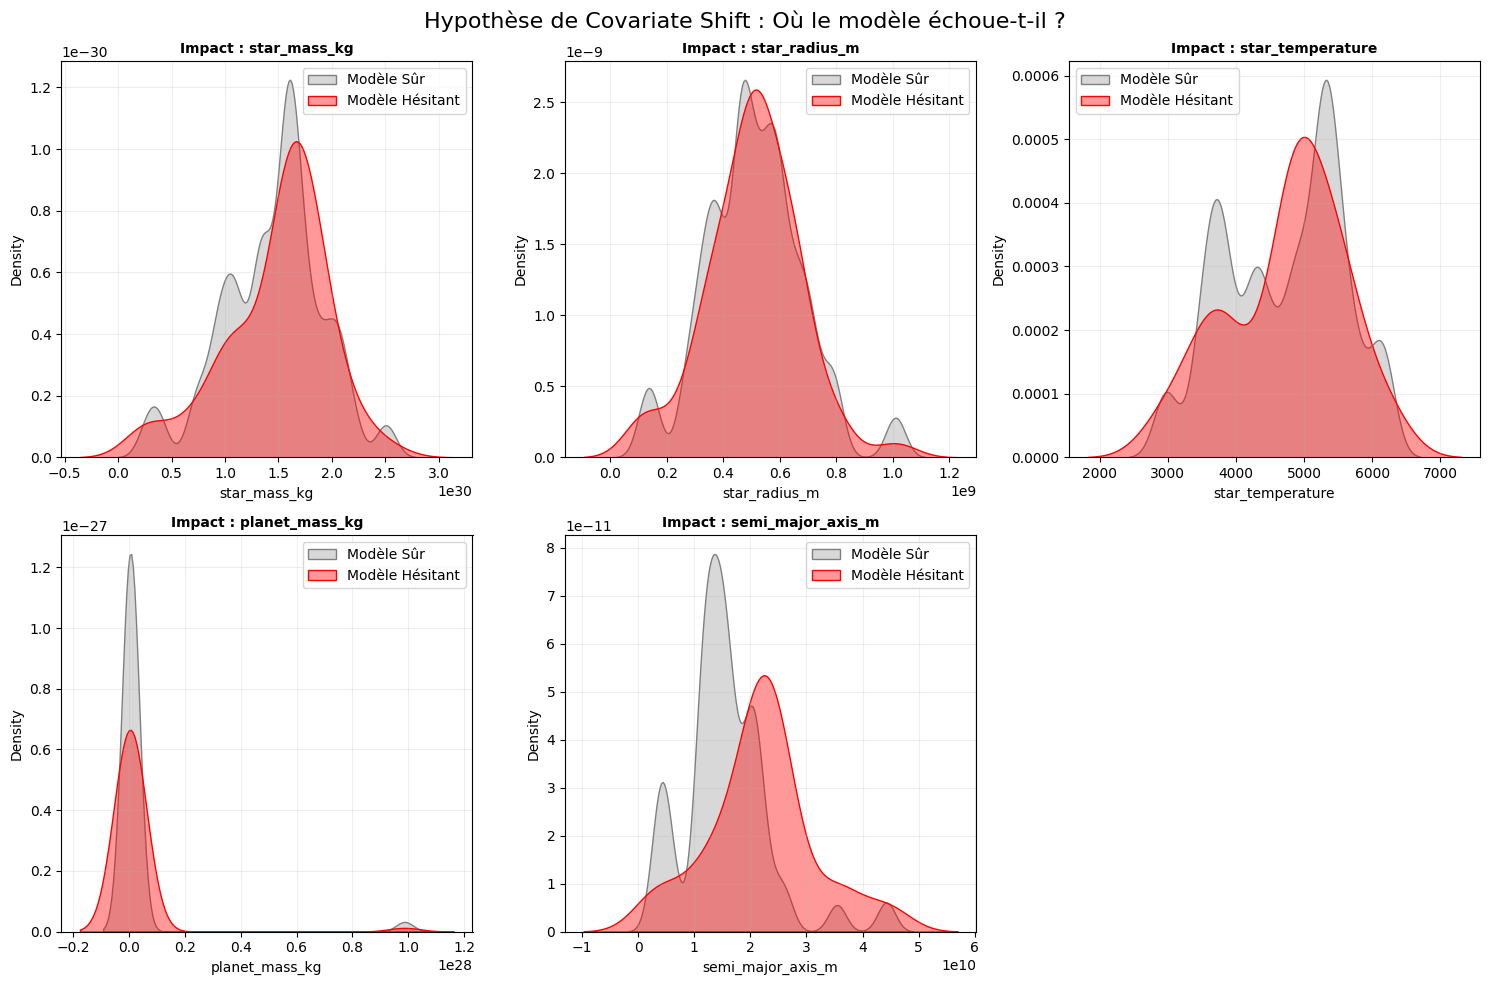

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Préparation des données

df_analyze = auxiliary_train.copy()
df_analyze['pred_xgboost'] = oof_cnn_h2o # On analyse l'EAU ici (change pour oof_clouds_xg si besoin)
df_analyze['target_reelle'] = targets_train['eau']

# Incertitude
mask_uncertain = (df_analyze['pred_xgboost'] > 0.35) & (df_analyze['pred_xgboost'] < 0.65)
mask_sure = (df_analyze['pred_xgboost'] < 0.2) | (df_analyze['pred_xgboost'] > 0.8)

data_uncertain = df_analyze[mask_uncertain]
data_sure = df_analyze[mask_sure]

print(f" Analyse des Incertitudes XGBoost :")
print(f"   - Nombre de cas incertains (0.35 < p < 0.65) : {len(data_uncertain)}")
print(f"   - Nombre de cas sûrs (p < 0.2 ou p > 0.8)    : {len(data_sure)}")

# Shift
features_physiques = df_analyze.columns.drop(['pred_xgboost', 'target_reelle']) # On prend les colonnes aux

plt.figure(figsize=(15, 10))

for i, col in enumerate(features_physiques):
    plt.subplot(2, 3, i + 1)

    # Distribution des cas sûrs
    sns.kdeplot(data_sure[col], label='Modèle Sûr', fill=True, color='grey', alpha=0.3)

    # Distribution des cas incertains
    sns.kdeplot(data_uncertain[col], label='Modèle Hésitant', fill=True, color='red', alpha=0.4)

    plt.title(f"Impact : {col}", fontsize=10, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.2)

plt.suptitle("Hypothèse de Covariate Shift : Où le modèle échoue-t-il ?", fontsize=16)
plt.tight_layout()
plt.show()

 Analyse des Incertitudes XGBoost :
   - Nombre de cas incertains (0.35 < p < 0.65) : 43
   - Nombre de cas sûrs (p < 0.2 ou p > 0.8)    : 2892


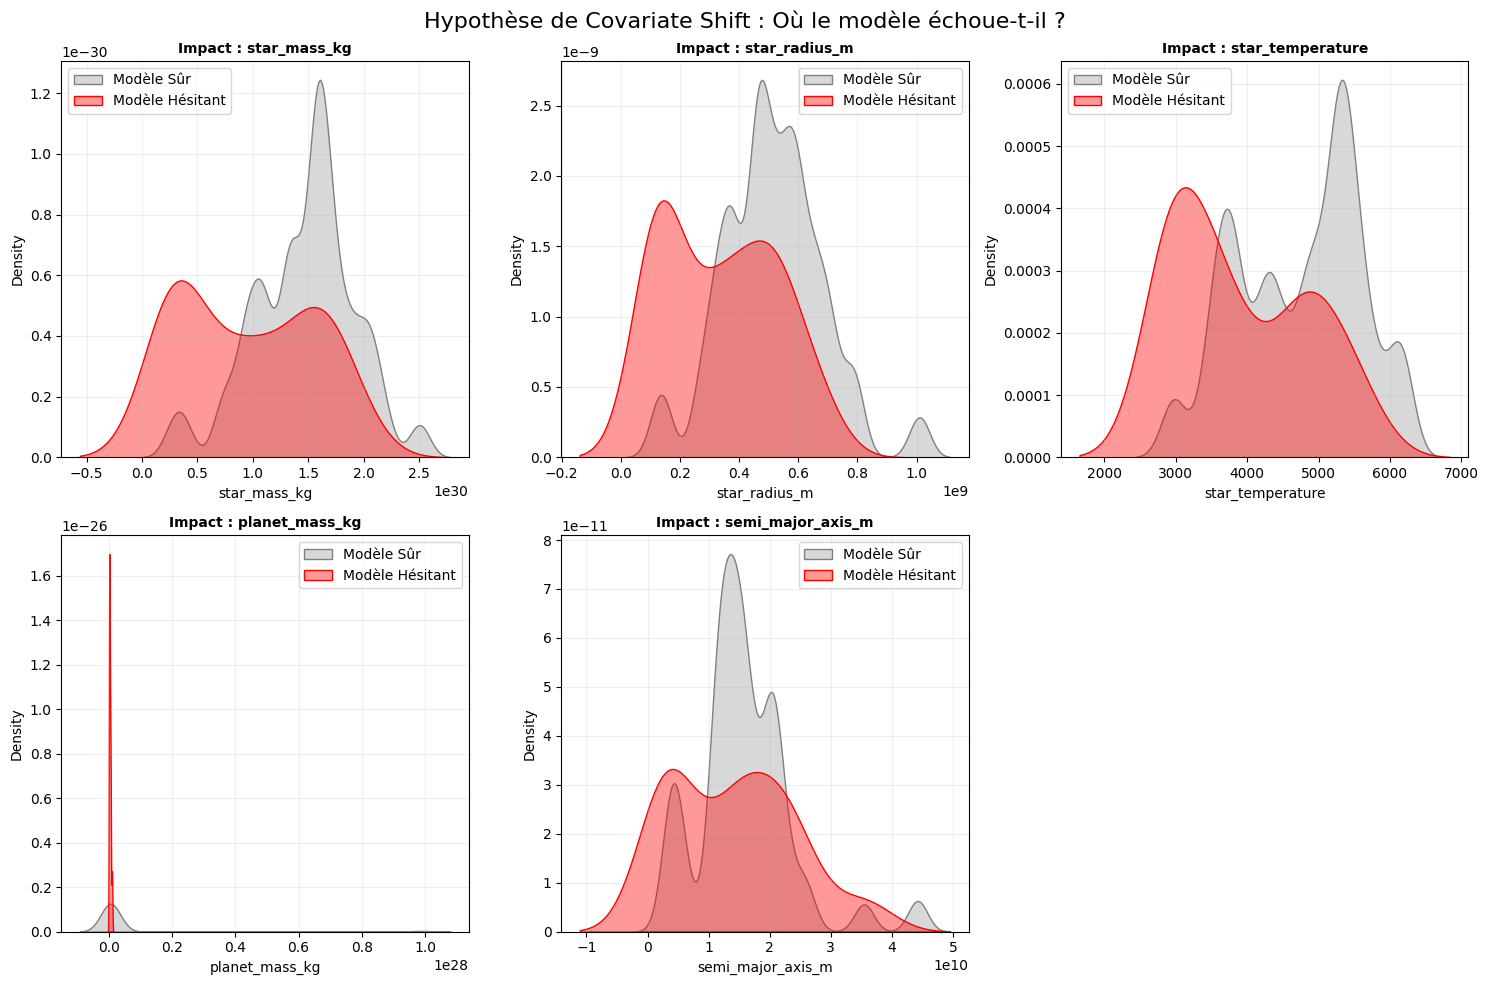

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Préparation des données
df_analyze = auxiliary_train.copy()
df_analyze['pred_xgboost'] = oof_h2o # On analyse l'EAU ici (change pour oof_clouds_xg si besoin)
df_analyze['target_reelle'] = targets_train['eau']

# Incertitude
mask_uncertain = (df_analyze['pred_xgboost'] > 0.35) & (df_analyze['pred_xgboost'] < 0.65)
mask_sure = (df_analyze['pred_xgboost'] < 0.2) | (df_analyze['pred_xgboost'] > 0.8)

data_uncertain = df_analyze[mask_uncertain]
data_sure = df_analyze[mask_sure]

print(f" Analyse des Incertitudes XGBoost :")
print(f"   - Nombre de cas incertains (0.35 < p < 0.65) : {len(data_uncertain)}")
print(f"   - Nombre de cas sûrs (p < 0.2 ou p > 0.8)    : {len(data_sure)}")

# Visualisation
features_physiques = df_analyze.columns.drop(['pred_xgboost', 'target_reelle']) # On prend les colonnes aux

plt.figure(figsize=(15, 10))

for i, col in enumerate(features_physiques):
    plt.subplot(2, 3, i + 1)

    # Distribution des cas sûrs
    sns.kdeplot(data_sure[col], label='Modèle Sûr', fill=True, color='grey', alpha=0.3)

    # Distribution des cas incertains
    sns.kdeplot(data_uncertain[col], label='Modèle Hésitant', fill=True, color='red', alpha=0.4)

    plt.title(f"Impact : {col}", fontsize=10, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.2)

plt.suptitle("Hypothèse de Covariate Shift : Où le modèle échoue-t-il ?", fontsize=16)
plt.tight_layout()
plt.show()